In [51]:
import time 
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog

%matplotlib inline

### Helper Functions

In [25]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [2]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

In [23]:
def plot_color_hist(img, nbins=32, bins_range=(0, 256)):
    rh, gh, bh, bincen, feature_vec = color_hist(img, nbins=nbins, bins_range=bins_range)

    # Plot a figure with all three bar charts
    if rh is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bincen, rh[0])
        plt.xlim(0, 256)
        plt.title('R Histogram')
        plt.subplot(132)
        plt.bar(bincen, gh[0])
        plt.xlim(0, 256)
        plt.title('G Histogram')
        plt.subplot(133)
        plt.bar(bincen, bh[0])
        plt.xlim(0, 256)
        plt.title('B Histogram')
        fig.tight_layout()
        plt.show()
    else:
        print('Your function is returning None for at least one variable...')

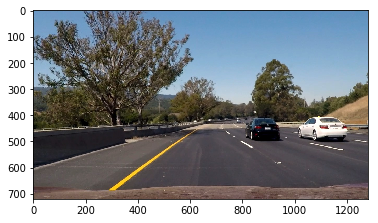

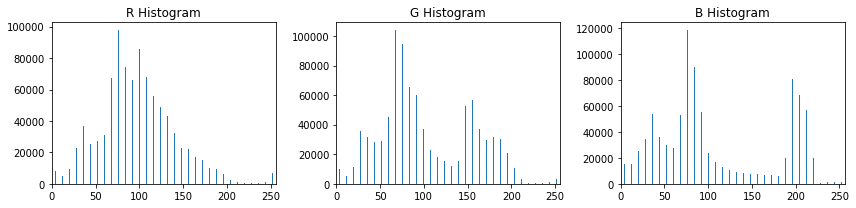

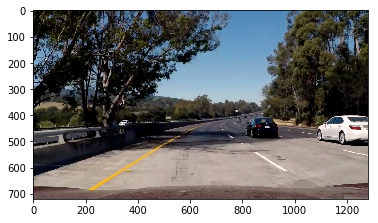

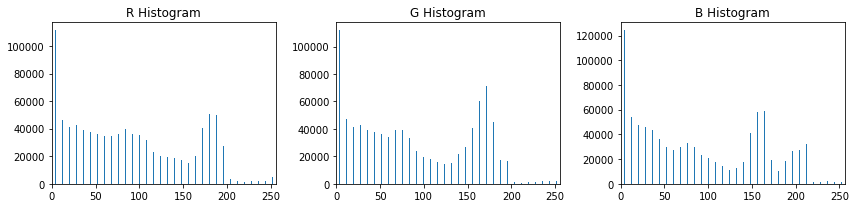

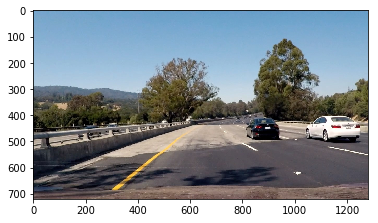

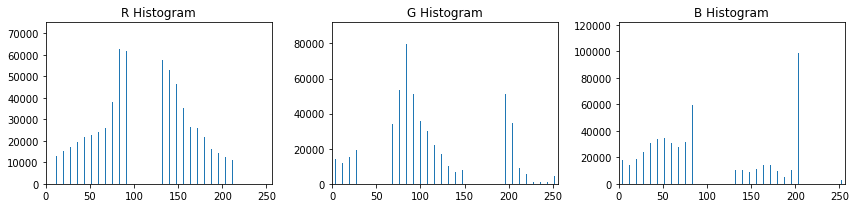

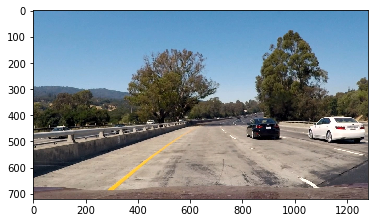

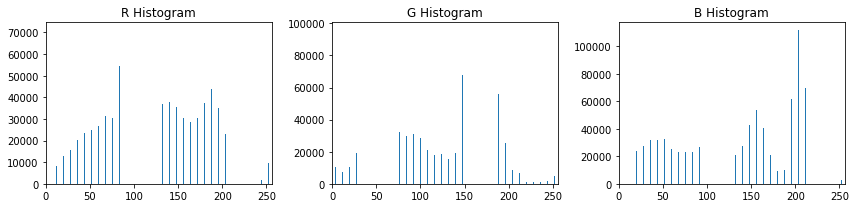

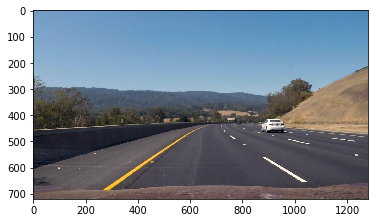

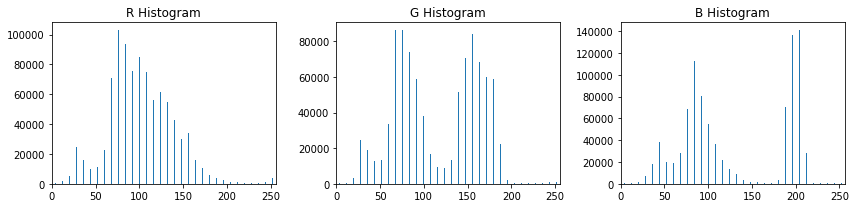

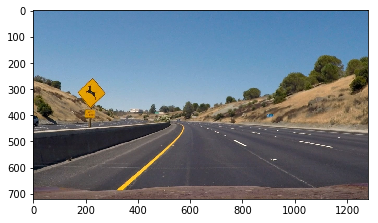

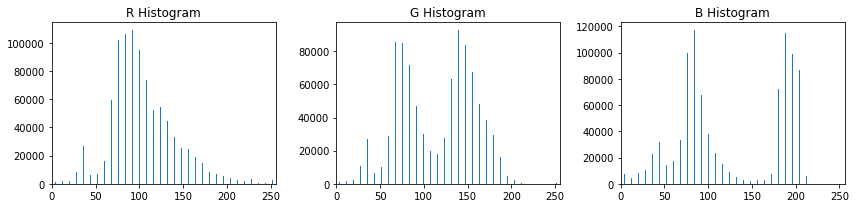

In [24]:
# plot histograms for whole images -> ignore this, it is irrelevant to the solution

for filename in glob.glob('test_images/*.jpg', recursive=True):
    img = mpimg.imread(filename)
    plt.imshow(img)
    # plt.close(fig)
    plot_color_hist(img)

In [110]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

In [103]:
def plot2(left, right, title_left='Left', title_right='Right', args_left={}, args_right={}):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    f.tight_layout()
    ax1.imshow(left, **args_left)
    ax1.set_title(title_left, fontsize=28)
    ax2.imshow(right, **args_right)
    ax2.set_title(title_right, fontsize=28)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

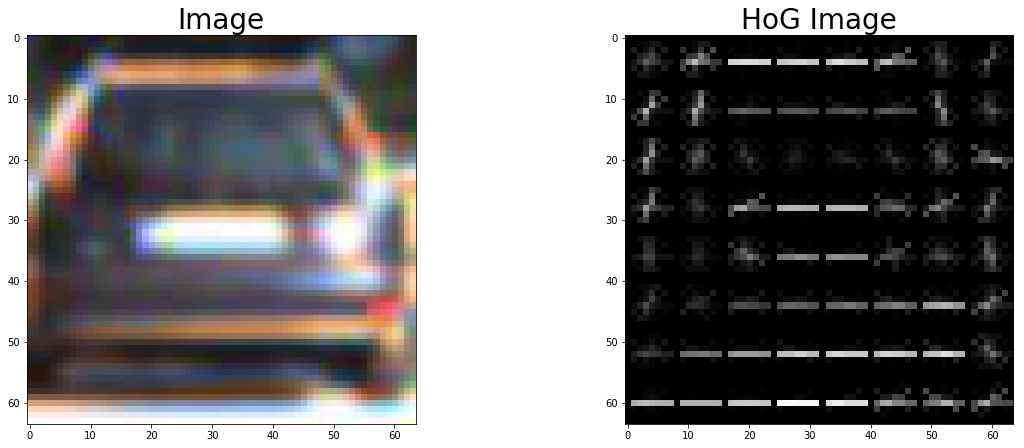

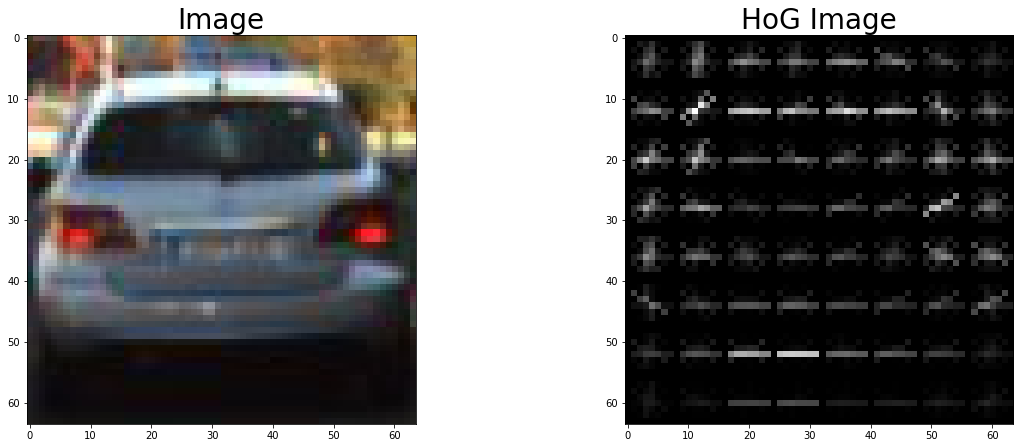

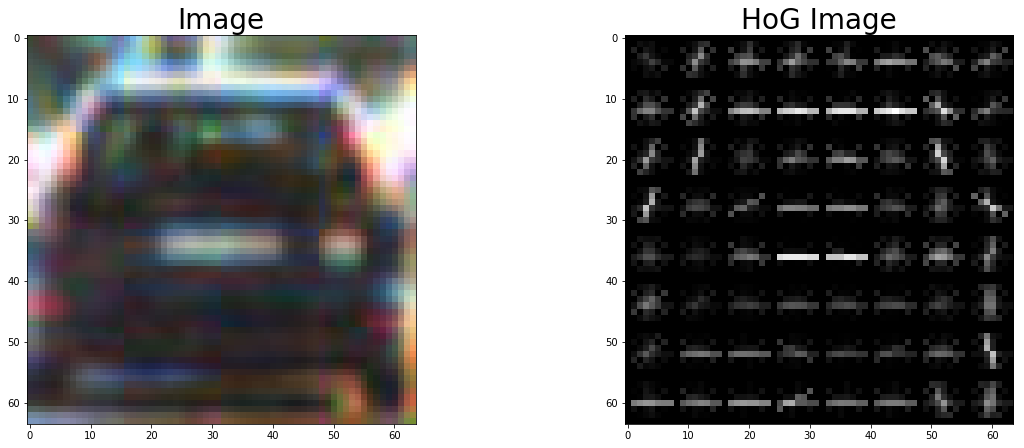

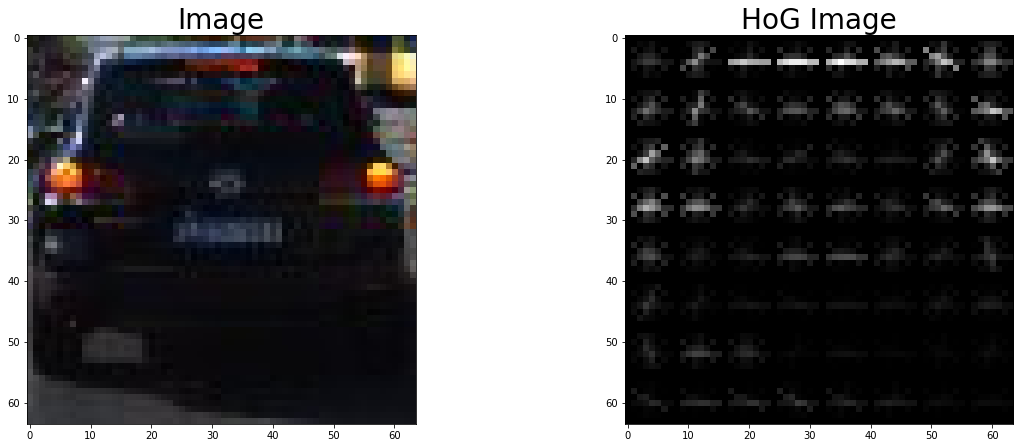

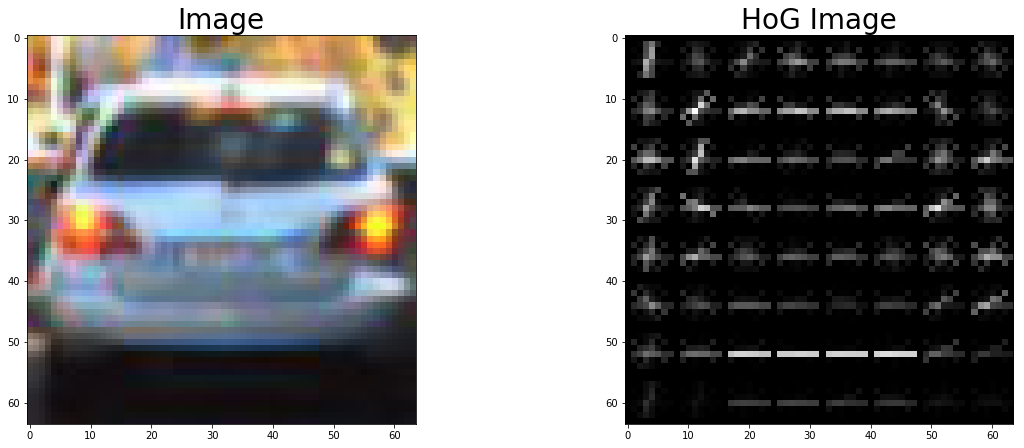

In [105]:
pix_per_cell = 8
cell_per_block = 2
orient = 9

for filename in glob.glob('data/vehicles_smallset/**/*.jpeg', recursive=True)[:5]:
    img = mpimg.imread(filename)
    features, hog_img = get_hog_features(img, orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True)
    
    plot2(img, hog_img, title_left="Image", title_right="HoG Image", args_left={'cmap': 'gray'}, args_right={'cmap': 'gray'})

In [42]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [43]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [45]:
# windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
#                     xy_window=(128, 128), xy_overlap=(0.5, 0.5))

In [168]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def extract_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
#     if spatial_feat == True:
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         #4) Append features to list
#         img_features.append(spatial_features)
#     #5) Compute histogram features if flag is set
#     if hist_feat == True:
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         #6) Append features to list
#         img_features.append(hist_features)
#     #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            # print(feature_image.shape, feature_image.dtype, feature_image[:,:,0].shape)
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

### Extract Features

In [170]:
cars = []
notcars = []
for file in glob.glob('data/vehicles/**/*.png'):
    cars.append(file)
# cars = np.asarray(cars)
    
for file in glob.glob('data/non-vehicles/**/*.png'):
    notcars.append(file)
# notcars = np.asarray(notcars)

print("{} car images, {} not-car images".format(len(cars), len(notcars)))

8792 car images, 8968 not-car images


In [171]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

In [172]:
before = time.time()
car_features = []

for file in cars:
    car_img = mpimg.imread(file)
    single_car_features = extract_features(car_img, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    car_features.append(single_car_features)

after = time.time()
print('Extracted HoG features for cars in {} seconds'.format(round(after - before, 2)))

Extracted HoG features for cars in 63.52 seconds


In [173]:
before = time.time()

notcar_features = []
for file in notcars:
    notcar_img = mpimg.imread(file)
    single_notcar_features = extract_features(notcar_img, color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features.append(single_notcar_features)
    
after = time.time()
print('Extracted HoG features for not-cars in {} seconds'.format(round(after - before, 2)))

Extracted HoG features for not-cars in 61.86 seconds


In [177]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

### Train SVC Classifier

In [182]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [183]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [184]:
# Use a linear SVC 
svc = SVC(kernel='rbf')
# Check the training time for the SVC
before = time.time()
svc.fit(X_train, y_train)
after = time.time()
print(round(after - before, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
before = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
after = time.time()
print(round(after - before, 5), 'Seconds to predict', n_predict,'labels with SVC')

194.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
For these 10 labels:  [0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
0.13642 Seconds to predict 10 labels with SVC


In [185]:
from sklearn.externals import joblib

In [187]:
joblib.dump(svc, 'models/svc-rbf.p')
# svc = joblib.load('models/svc-rbf.p') 

['models/svc-rbf.p']

### Find Cars in Image

In [191]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [223]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    rectangles = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
 
            test_features = X_scaler.transform(hog_features).reshape(1, -1)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                rect = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                rectangles.append(rect)

                cv2.rectangle(draw_img, rect[0], rect[1],(0,0,255),6) 
                
    return rectangles, draw_img

In [227]:
def find_cars_scaled(img):
    rectangles = []
    
    # Use rectangles of different scales - 
    # rectangles further away (smaller values for ystart and ystop) are smaller (smaller values for scale) 
    # and vice versa
    rect, draw_img = find_cars(img, svc=svc, X_scaler=X_scaler, orient=orient, 
                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                         ystart=400, ystop=500, scale=1.5)
    rectangles.extend(rect)
    
    rect, draw_img = find_cars(draw_img, svc=svc, X_scaler=X_scaler, orient=orient, 
                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                         ystart=400, ystop=600, scale=2)
    rectangles.extend(rect)
    
    rect, draw_img = find_cars(draw_img, svc=svc, X_scaler=X_scaler, orient=orient, 
                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                         ystart=500, ystop=600, scale=2)
    rectangles.extend(rect)
    
    rect, draw_img = find_cars(draw_img, svc=svc, X_scaler=X_scaler, orient=orient, 
                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                         ystart=400, ystop=600, scale=3.0)
    rectangles.extend(rect)
    
    return rectangles, draw_img

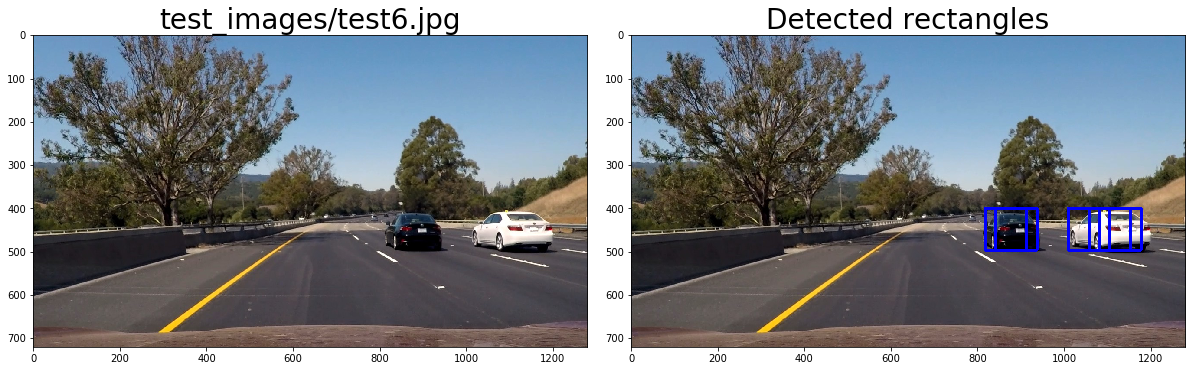

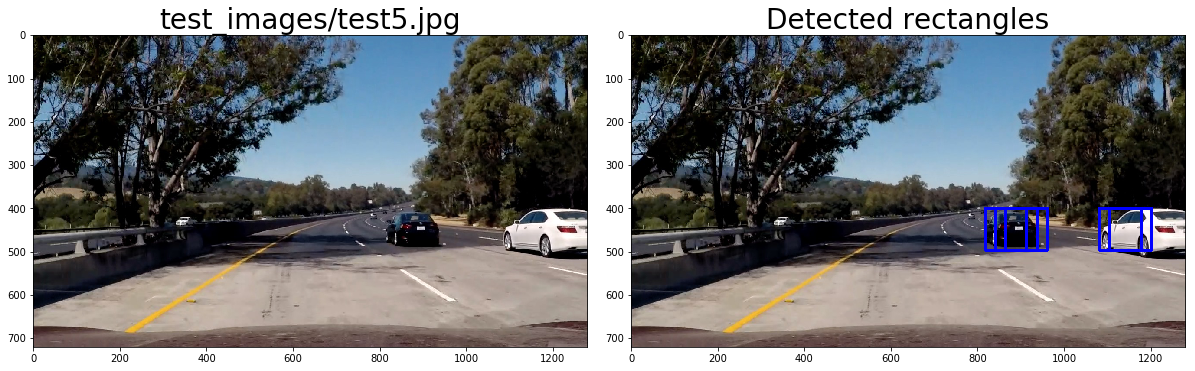

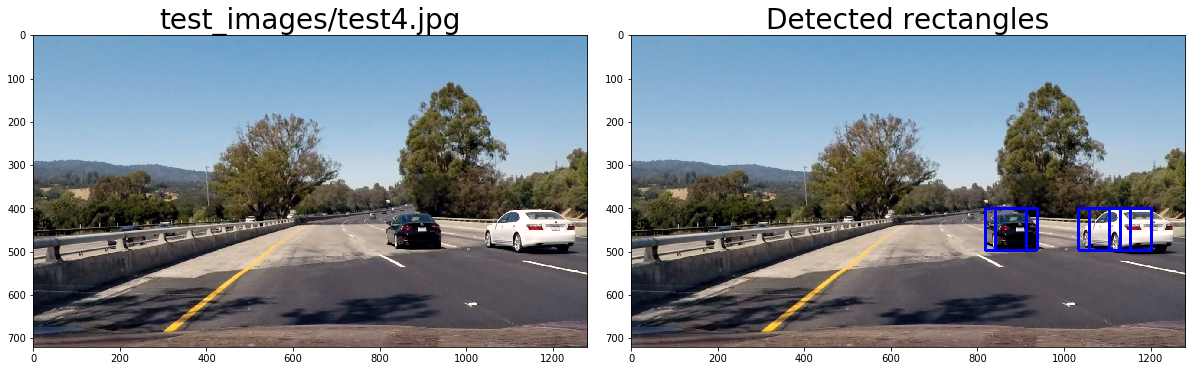

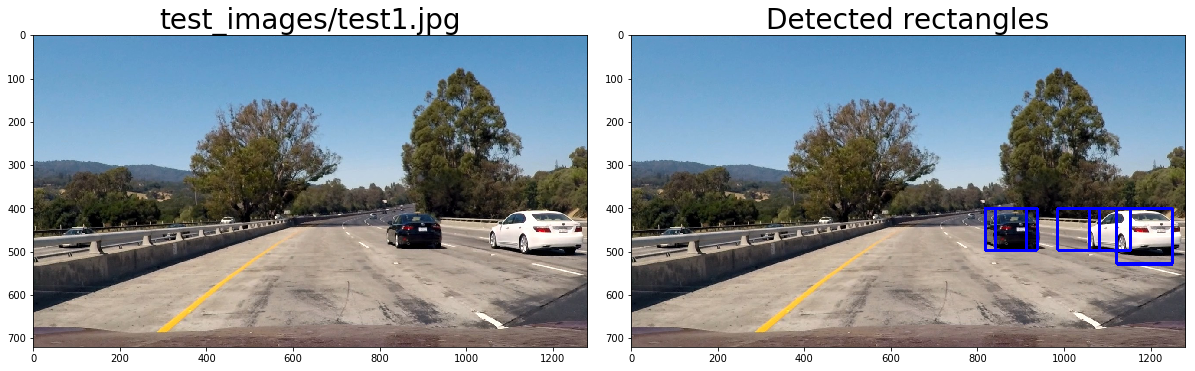

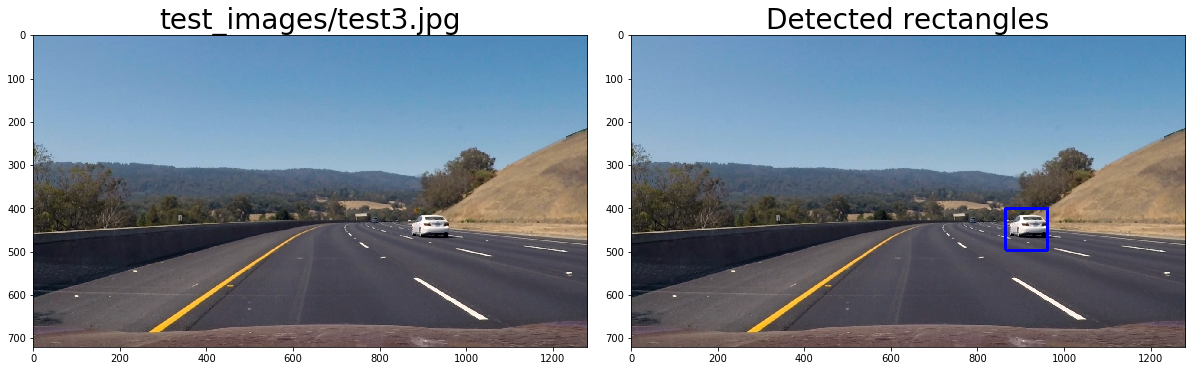

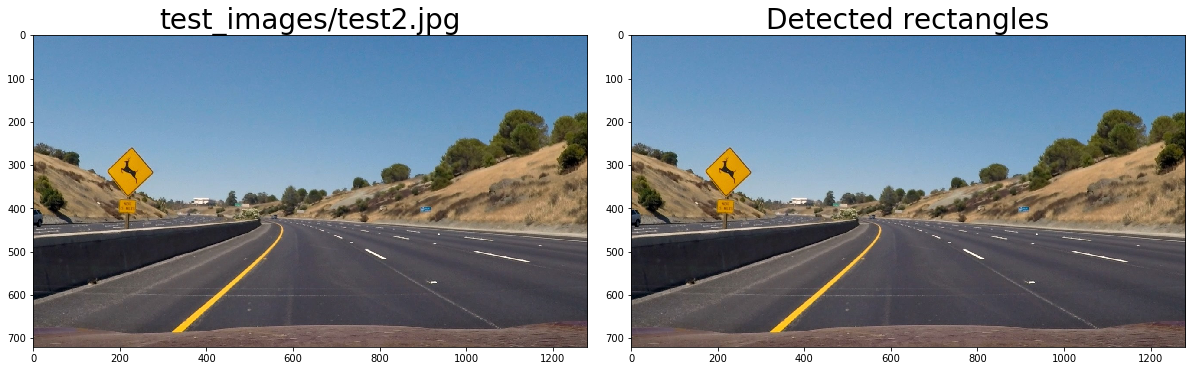

In [228]:
for file in glob.glob('test_images/*.jpg'):
    img = mpimg.imread(file)
    _, draw_img = find_cars_scaled(img)
    
    plot2(img, draw_img, title_left=file, title_right="Detected rectangles")

### Add Heatmap

In [256]:
from scipy.ndimage.measurements import label

In [248]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [249]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [253]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [254]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

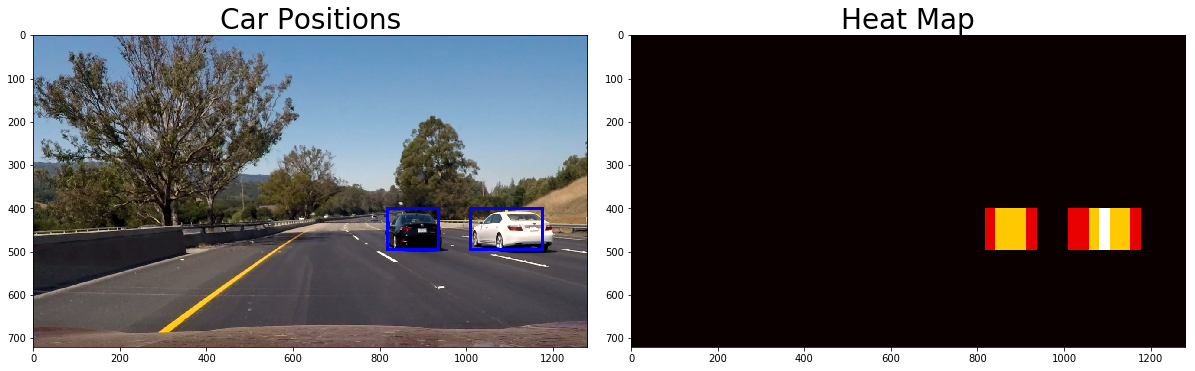

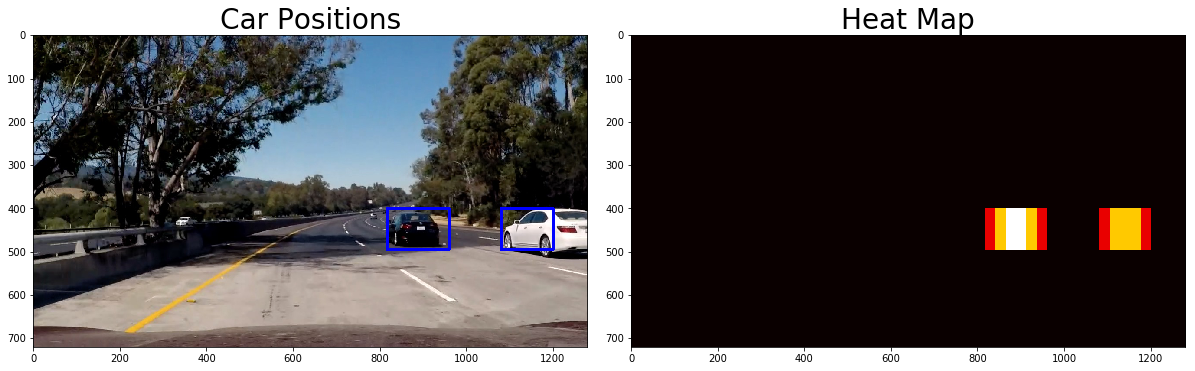

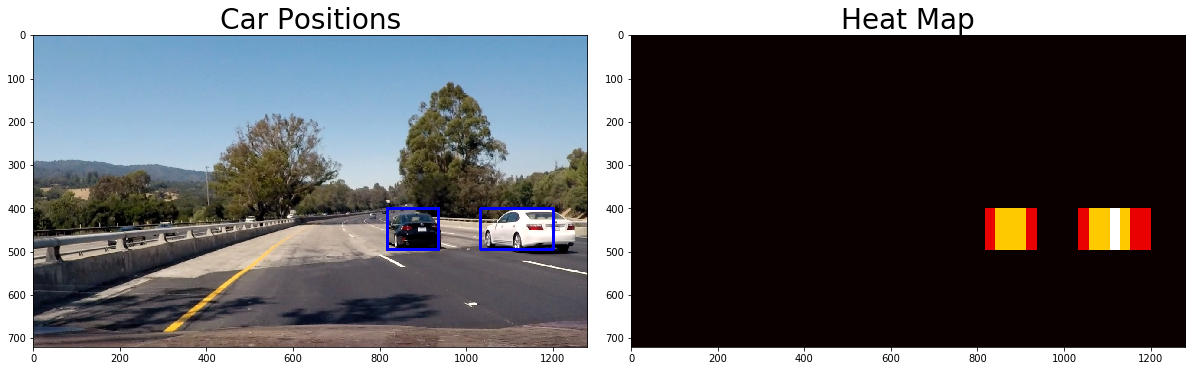

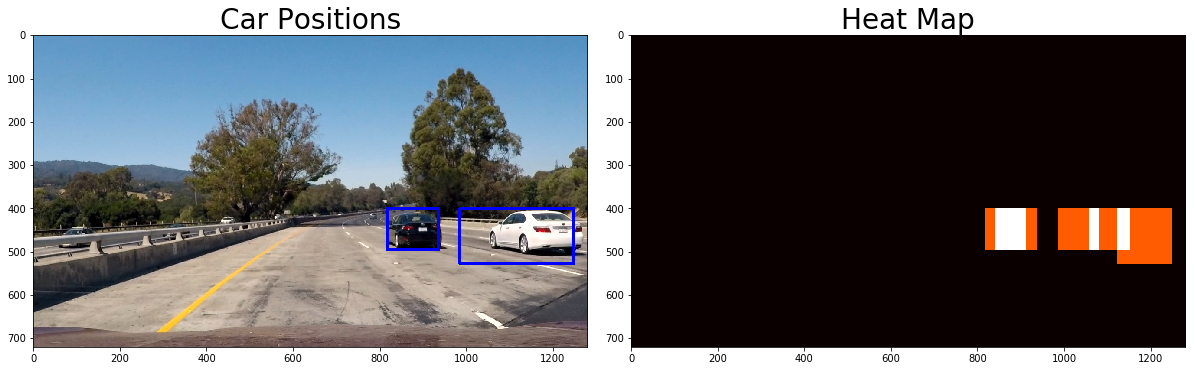

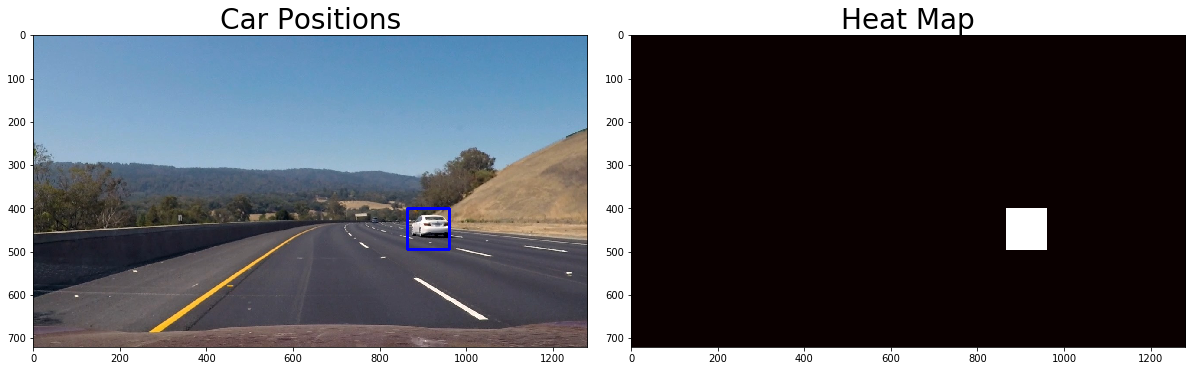

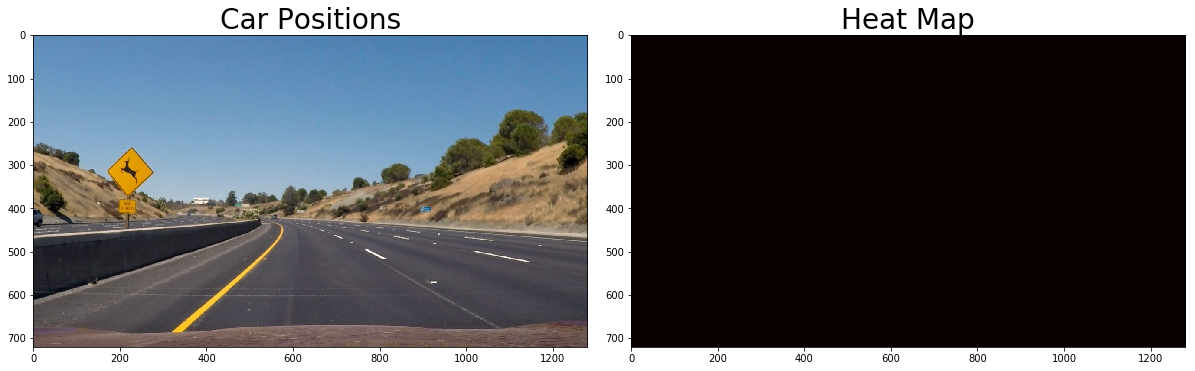

In [263]:
for file in glob.glob('test_images/*.jpg'):
    img = mpimg.imread(file)
    
    windows, _ = find_cars_scaled(img)
    
    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, windows)
        
    # Apply threshold to help remove false positives
    # heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    plot2(draw_img, heatmap, title_left="Car Positions", title_right="Heat Map", args_right={'cmap': 'hot'})

In [264]:
def find_cars_combined_rect(img):
    windows, _ = find_cars_scaled(img)
     
    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, windows)
        
    # most rectangles don't overlap -> adding a threshold makes the end result worse 
    # Apply threshold to help remove false positives
    # heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

### Apply to Video Stream

In [212]:
from moviepy.editor import VideoFileClip
import imageio
imageio.plugins.ffmpeg.download()
from IPython.display import HTML

In [213]:
# test_video_input = 'test_video.mp4'
# test_video_output = 'output_videos/test_video_output.mp4'

In [267]:
test_video_input = 'project_video.mp4'
test_video_output = 'output_videos/project_video_output.mp4'

In [268]:
clip1 = VideoFileClip(test_video_input)
clip = clip1.fl_image(find_cars_combined_rect)
%time clip.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [1:04:51<00:02,  2.92s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 59min 37s, sys: 29.5 s, total: 1h 7s
Wall time: 1h 4min 51s


In [269]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_output))